In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import time
import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, train_test_split
import matplotlib.pyplot as plt

import os
print(os.listdir("D:\Work\microsoft-malware-prediction"))

['sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float32',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float32',
        'AVProductsEnabled':                                    'float32',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float32',
        'GeoNameIdentifier':                                    'float32',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float32',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float32',
        'IeVerIdentifier':                                      'float32',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float32',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float32',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float32',
        'Census_ProcessorManufacturerIdentifier':               'float32',
        'Census_ProcessorModelIdentifier':                      'float32',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float32',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float32',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float32',
        'Census_IsFlightsDisabled':                             'float32',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float32',
        'Census_FirmwareManufacturerIdentifier':                'float32',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float32',
        'Census_IsVirtualDevice':                               'float32',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float32',
        'Wdft_IsGamer':                                         'float32',
        'Wdft_RegionIdentifier':                                'float32',
        'HasDetections':                                        'int8'
        }

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics]
categorical_columns = [c for c,v in dtypes.items() if v not in numerics]

In [4]:
%%time
train = pd.read_csv('D:/Work/microsoft-malware-prediction/train.csv', dtype=dtypes)

CPU times: total: 1min 15s
Wall time: 2min 8s


In [5]:
train = reduce_mem_usage(train)

Mem. usage decreased to 2760.40 Mb (0.0% reduction)


In [6]:
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
28,PuaMode,2,99.974119,99.974119,category
41,Census_ProcessorClass,3,99.589407,99.589407,category
8,DefaultBrowsersIdentifier,2017,95.141637,95.141637,float32
68,Census_IsFlightingInternal,2,83.044030,83.044030,float32
52,Census_InternalBatteryType,78,71.046809,71.046809,category
...,...,...,...,...,...
1,ProductName,6,0.000000,98.935569,category
45,Census_HasOpticalDiskDrive,2,0.000000,92.281272,int8
54,Census_OSVersion,469,0.000000,15.845202,category
55,Census_OSArchitecture,3,0.000000,90.858045,category


In [7]:
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)

In [8]:
train = train[good_cols]

In [9]:
test_dtypes = {k: v for k, v in dtypes.items() if k in good_cols}
test = pd.read_csv('D:/Work/microsoft-malware-prediction/test.csv', dtype=test_dtypes, usecols=good_cols[:-1])
test.loc[6529507, 'OsBuildLab'] = '17134.1.amd64fre.rs4_release.180410-1804'
test['OsBuildLab'] = test['OsBuildLab'].fillna('17134.1.amd64fre.rs4_release.180410-1804')
test = reduce_mem_usage(test)

Mem. usage decreased to 2034.04 Mb (0.0% reduction)


In [10]:
train.head()

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,...,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,1.1.15100.1,4.18.1807.18075,1.273.1735.0,53447.0,1.0,29,128035.0,18.0,35.0,...,NaN,NaN,628.0,36144.0,0,NaN,0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,1.1.14600.4,4.13.17134.1,1.263.48.0,53447.0,1.0,93,1482.0,18.0,119.0,...,NaN,NaN,628.0,57858.0,0,NaN,0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,1.1.15100.1,4.18.1807.18075,1.273.1341.0,53447.0,1.0,86,153579.0,18.0,64.0,...,NaN,NaN,142.0,52682.0,0,NaN,0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,1.1.15100.1,4.18.1807.18075,1.273.1527.0,53447.0,1.0,88,20710.0,NaN,117.0,...,NaN,NaN,355.0,20050.0,0,NaN,0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,1.1.15100.1,4.18.1807.18075,1.273.1379.0,53447.0,1.0,18,37376.0,NaN,277.0,...,0.0,0.0,355.0,19844.0,0,0.0,0,0.0,1.0,1


In [11]:
# Xử lý giá trị thiếu
for col in train.columns:
    if train[col].dtype == 'category':
        train[col] = train[col].fillna(train[col].mode()[0])
    else:
        train[col] = train[col].fillna(train[col].mean())

In [12]:
# Mã hóa các biến phân loại
for col in train.select_dtypes(include=['category']).columns:
    if train[col].nunique() > 10:
        le = LabelEncoder()
        train[col] = le.fit_transform(train[col])
    else:
        train = pd.get_dummies(train, columns=[col], drop_first=True)

In [13]:
# Tách dữ liệu thành tập huấn luyện và tập kiểm tra
from sklearn.model_selection import train_test_split
X = train.drop('HasDetections', axis=1)
y = train['HasDetections']
X_sample, _, y_sample, _ = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)


In [14]:
# Chuẩn hóa dữ liệu
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# Hàm đánh giá mô hình
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    results = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {results['accuracy']}")
    print(f"Precision: {results['precision']}")
    print(f"Recall: {results['recall']}")
    print(f"F1 Score: {results['f1_score']}")
    print(f"ROC AUC: {results['roc_auc']}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    return results

In [16]:
def save_results_to_csv(results, filename):
    results_df = pd.DataFrame([results])
    results_df.to_csv(filename, index=False)

In [17]:
def plot_metrics(results, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(results.keys())[:-2], y=list(results.values())[:-2])
    plt.title(title)
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.show()

In [18]:
def plot_roc_curve(y_test, y_pred_proba, title):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [19]:
def plot_confusion_matrix(conf_matrix, title):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

Model: LogisticRegression
Accuracy: 0.6149324874355313
Precision: 0.6209691752620073
Recall: 0.5880155958541956
F1 Score: 0.6040432738646662
ROC AUC: 0.6642009863958346
[[458517 255911]
 [293749 419261]]
              precision    recall  f1-score   support

           0       0.61      0.64      0.63    714428
           1       0.62      0.59      0.60    713010

    accuracy                           0.61   1427438
   macro avg       0.62      0.61      0.61   1427438
weighted avg       0.62      0.61      0.61   1427438



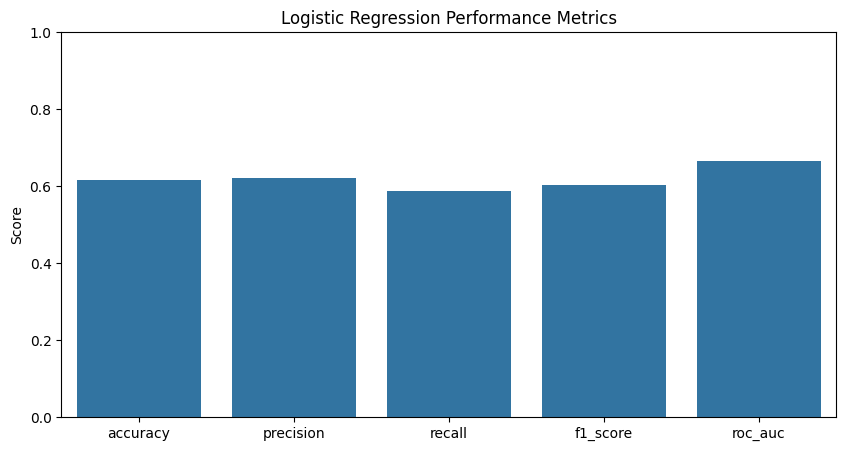

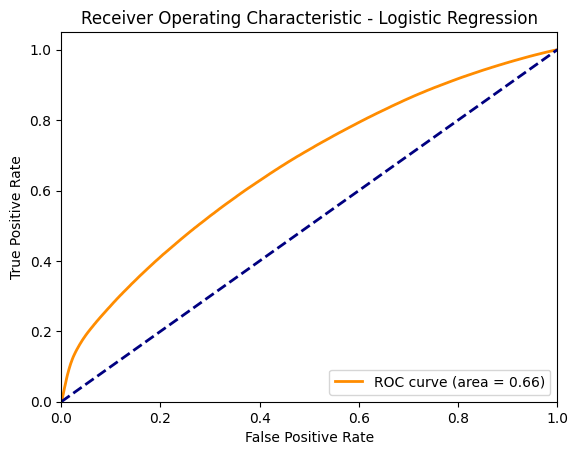

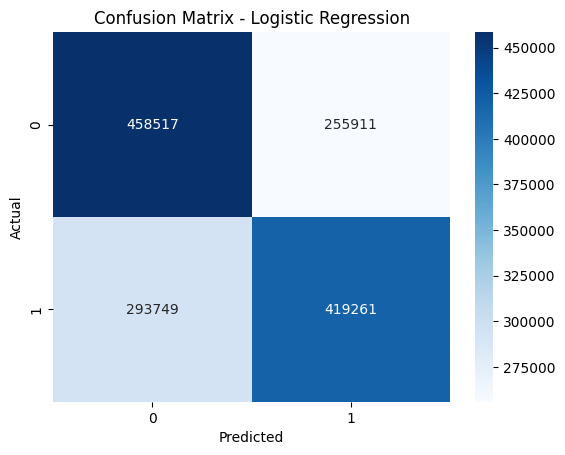

In [20]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

results_log_reg = evaluate_model(log_reg, X_test_scaled, y_test)

# Lưu kết quả vào CSV
save_results_to_csv(results_log_reg, 'log_reg_results.csv')

# Vẽ biểu đồ
plot_metrics(results_log_reg, 'Logistic Regression Performance Metrics')

# Vẽ biểu đồ ROC
y_pred_proba_log_reg = log_reg.predict_proba(X_test_scaled)[:, 1]
plot_roc_curve(y_test, y_pred_proba_log_reg, 'Receiver Operating Characteristic - Logistic Regression')

# Vẽ confusion matrix
plot_confusion_matrix(results_log_reg['confusion_matrix'], 'Confusion Matrix - Logistic Regression')

Model: DecisionTreeClassifier
Accuracy: 0.5760061032423125
Precision: 0.5753843528422737
Recall: 0.5769119647690776
F1 Score: 0.5761471462196927
ROC AUC: 0.5760070022213872
[[410869 303559]
 [301666 411344]]
              precision    recall  f1-score   support

           0       0.58      0.58      0.58    714428
           1       0.58      0.58      0.58    713010

    accuracy                           0.58   1427438
   macro avg       0.58      0.58      0.58   1427438
weighted avg       0.58      0.58      0.58   1427438



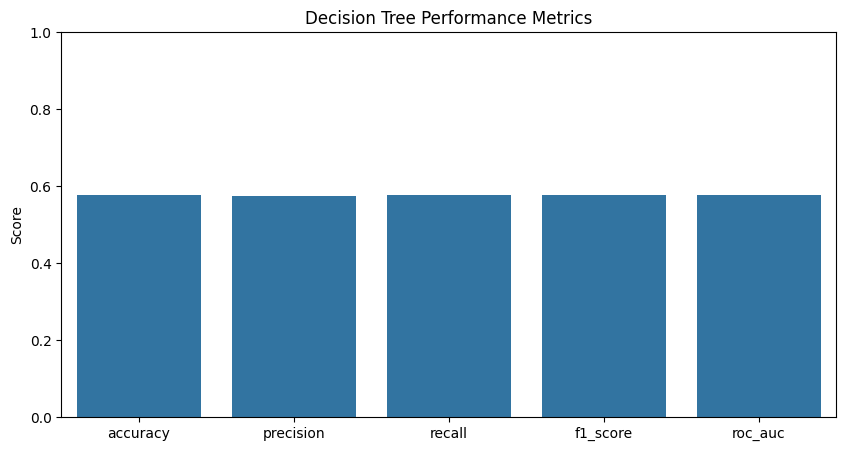

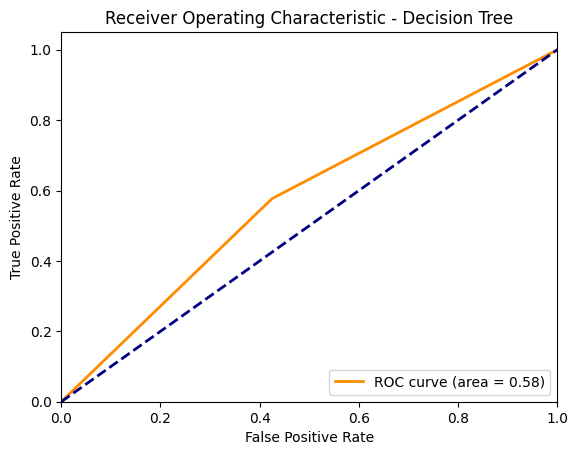

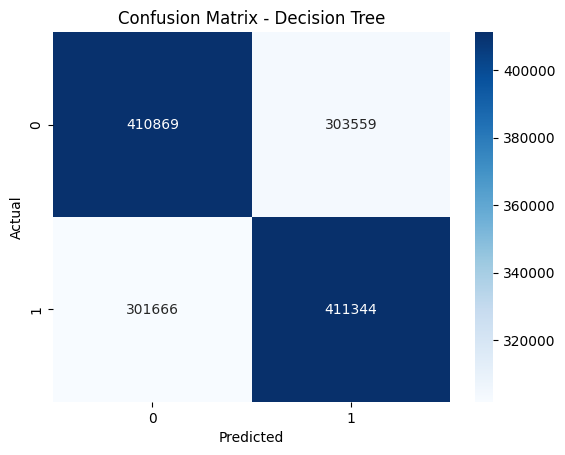

In [21]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train_scaled, y_train)

results_decision_tree = evaluate_model(decision_tree, X_test_scaled, y_test)

# Lưu kết quả vào CSV
save_results_to_csv(results_decision_tree, 'decision_tree_results.csv')

# Vẽ biểu đồ
plot_metrics(results_decision_tree, 'Decision Tree Performance Metrics')

# Vẽ biểu đồ ROC
y_pred_proba_decision_tree = decision_tree.predict_proba(X_test_scaled)[:, 1]
plot_roc_curve(y_test, y_pred_proba_decision_tree, 'Receiver Operating Characteristic - Decision Tree')

# Vẽ confusion matrix
plot_confusion_matrix(results_decision_tree['confusion_matrix'], 'Confusion Matrix - Decision Tree')

Model: GradientBoostingClassifier
Accuracy: 0.6355701613660278
Precision: 0.6344248099804368
Recall: 0.6381200824672866
F1 Score: 0.6362670809755183
ROC AUC: 0.6945255432536809
[[452251 262177]
 [258024 454986]]
              precision    recall  f1-score   support

           0       0.64      0.63      0.63    714428
           1       0.63      0.64      0.64    713010

    accuracy                           0.64   1427438
   macro avg       0.64      0.64      0.64   1427438
weighted avg       0.64      0.64      0.64   1427438



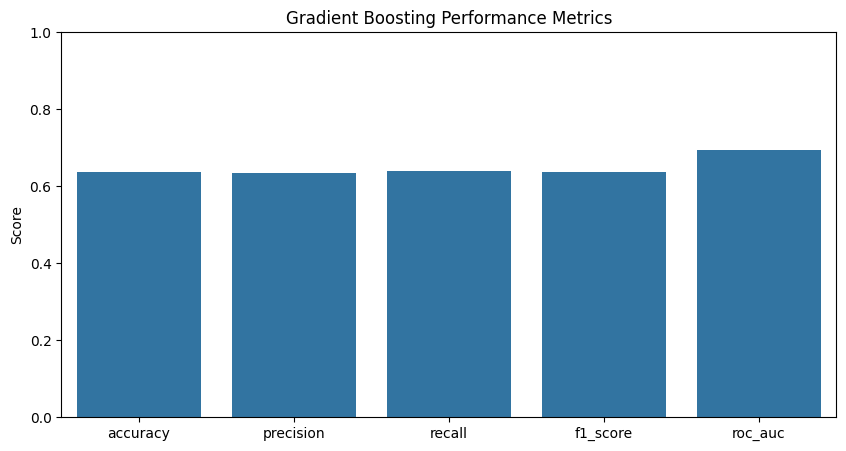

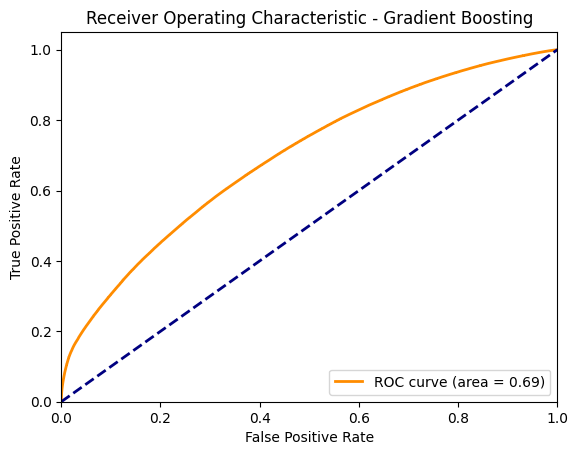

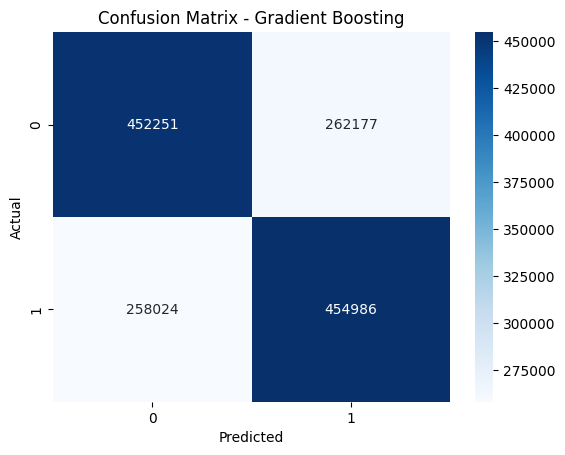

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=42)
gradient_boosting.fit(X_train_scaled, y_train)

results_gradient_boosting = evaluate_model(gradient_boosting, X_test_scaled, y_test)

# Lưu kết quả vào CSV
save_results_to_csv(results_gradient_boosting, 'gradient_boosting_results.csv')

# Vẽ biểu đồ
plot_metrics(results_gradient_boosting, 'Gradient Boosting Performance Metrics')

# Vẽ biểu đồ ROC
y_pred_proba_gradient_boosting = gradient_boosting.predict_proba(X_test_scaled)[:, 1]
plot_roc_curve(y_test, y_pred_proba_gradient_boosting, 'Receiver Operating Characteristic - Gradient Boosting')

# Vẽ confusion matrix
plot_confusion_matrix(results_gradient_boosting['confusion_matrix'], 'Confusion Matrix - Gradient Boosting')

Model: XGBClassifier
Accuracy: 0.6589904430174901
Precision: 0.660881091351788
Recall: 0.6517215747324722
F1 Score: 0.6562693748773072
ROC AUC: 0.723220622874526
[[475984 238444]
 [248326 464684]]
              precision    recall  f1-score   support

           0       0.66      0.67      0.66    714428
           1       0.66      0.65      0.66    713010

    accuracy                           0.66   1427438
   macro avg       0.66      0.66      0.66   1427438
weighted avg       0.66      0.66      0.66   1427438



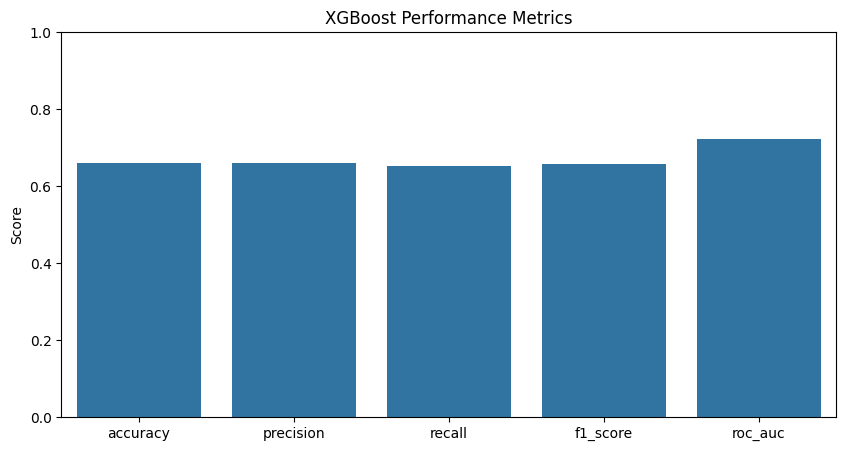

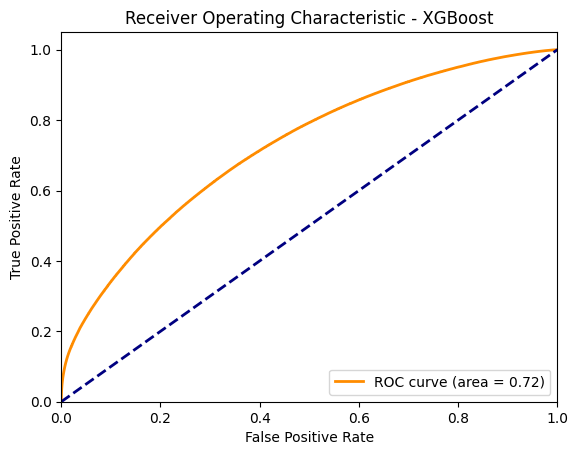

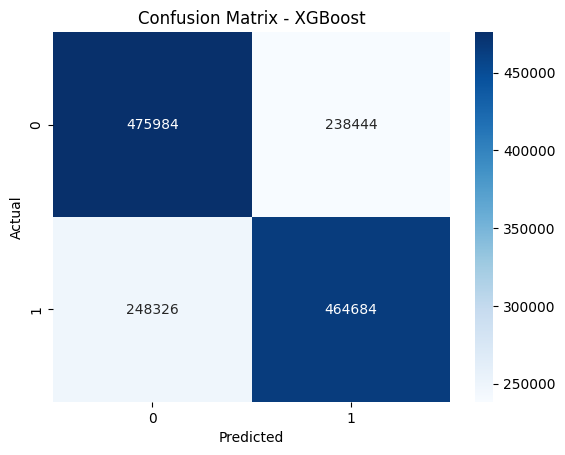

In [23]:
import xgboost as xgb

xgboost = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgboost.fit(X_train_scaled, y_train)

results_xgboost = evaluate_model(xgboost, X_test_scaled, y_test)

# Lưu kết quả vào CSV
save_results_to_csv(results_xgboost, 'xgboost_results.csv')

# Vẽ biểu đồ
plot_metrics(results_xgboost, 'XGBoost Performance Metrics')

# Vẽ biểu đồ ROC
y_pred_proba_xgboost = xgboost.predict_proba(X_test_scaled)[:, 1]
plot_roc_curve(y_test, y_pred_proba_xgboost, 'Receiver Operating Characteristic - XGBoost')

# Vẽ confusion matrix
plot_confusion_matrix(results_xgboost['confusion_matrix'], 'Confusion Matrix - XGBoost')

Model: GaussianNB
Accuracy: 0.565490760369277
Precision: 0.5432864985316884
Recall: 0.8165481550048387
F1 Score: 0.652461072177218
ROC AUC: 0.6333613429091532
[[224996 489432]
 [130803 582207]]
              precision    recall  f1-score   support

           0       0.63      0.31      0.42    714428
           1       0.54      0.82      0.65    713010

    accuracy                           0.57   1427438
   macro avg       0.59      0.57      0.54   1427438
weighted avg       0.59      0.57      0.54   1427438



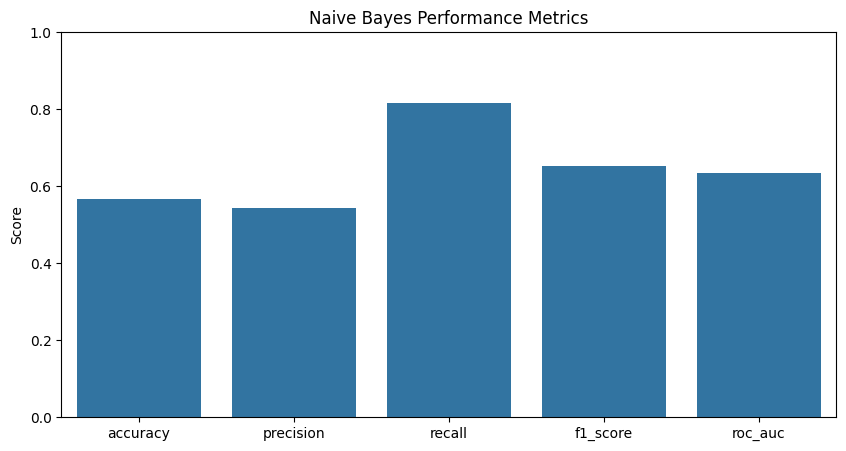

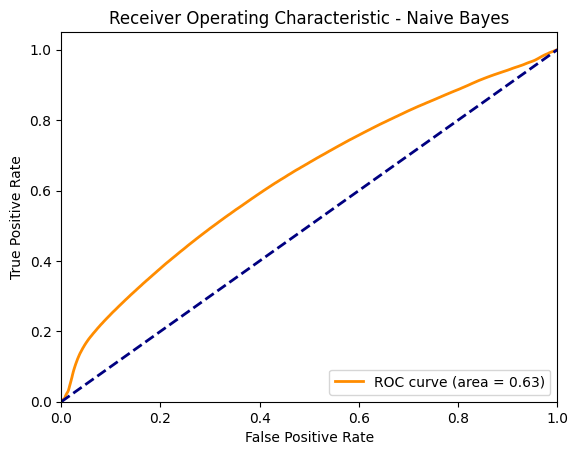

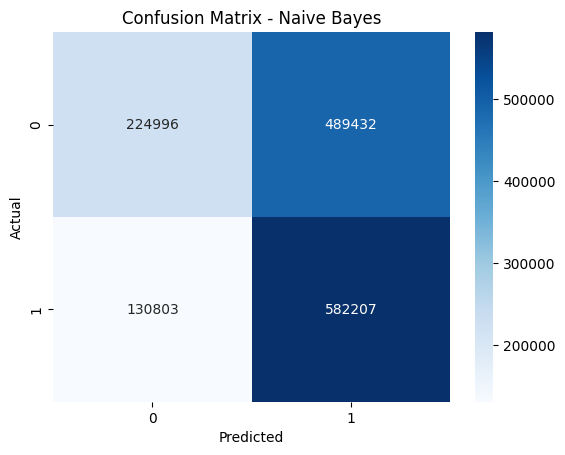

In [24]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
naive_bayes.fit(X_train_scaled, y_train)

results_naive_bayes = evaluate_model(naive_bayes, X_test_scaled, y_test)

# Lưu kết quả vào CSV
save_results_to_csv(results_naive_bayes, 'naive_bayes_results.csv')

# Vẽ biểu đồ
plot_metrics(results_naive_bayes, 'Naive Bayes Performance Metrics')

# Vẽ biểu đồ ROC
y_pred_proba_naive_bayes = naive_bayes.predict_proba(X_test_scaled)[:, 1]
plot_roc_curve(y_test, y_pred_proba_naive_bayes, 'Receiver Operating Characteristic - Naive Bayes')

# Vẽ confusion matrix
plot_confusion_matrix(results_naive_bayes['confusion_matrix'], 'Confusion Matrix - Naive Bayes')

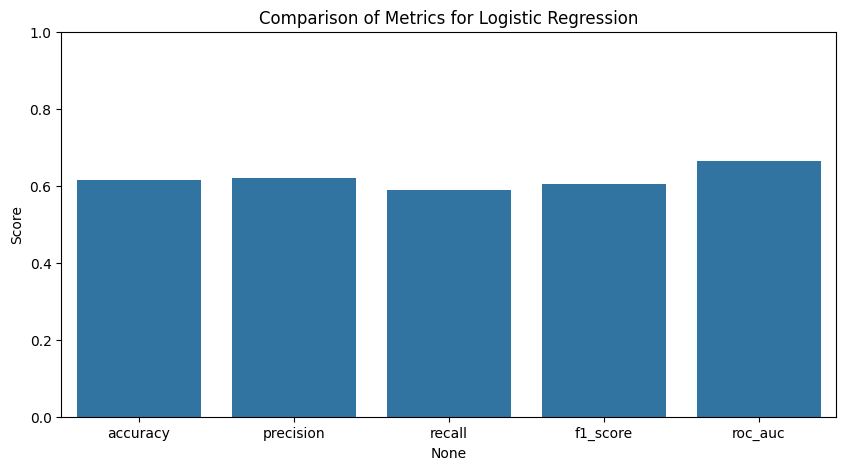

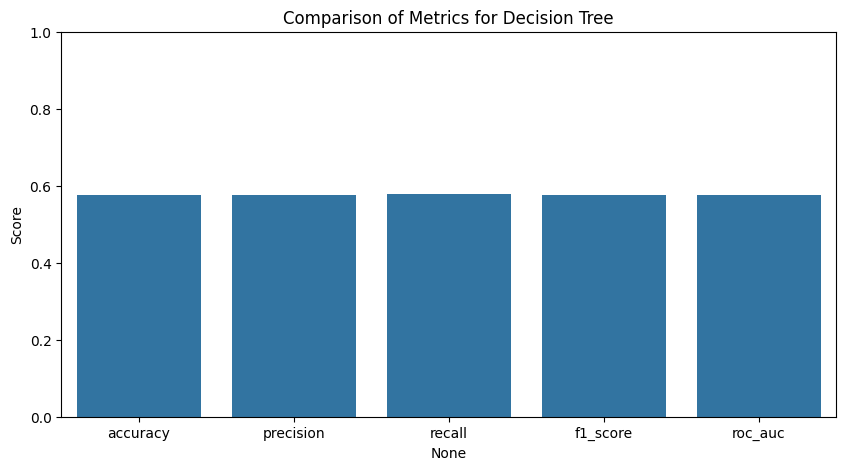

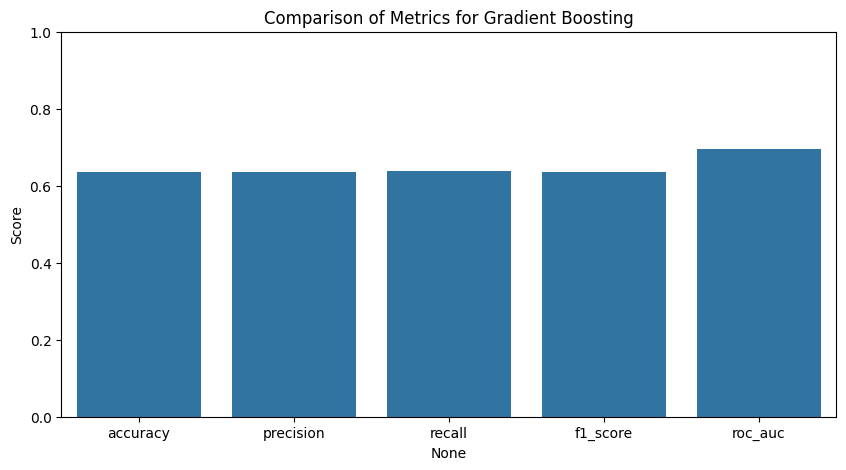

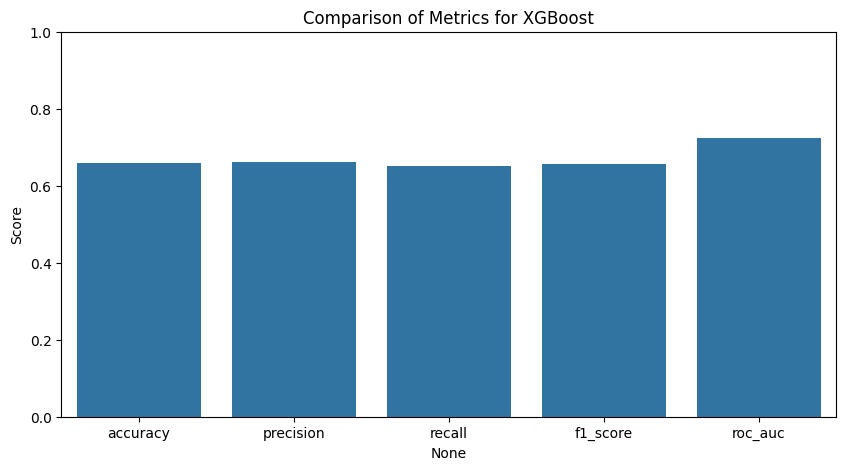

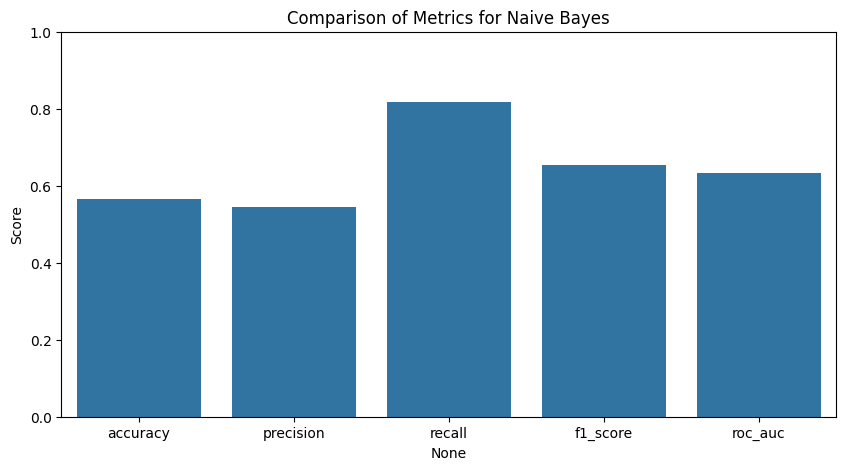

<Figure size 1500x1000 with 0 Axes>

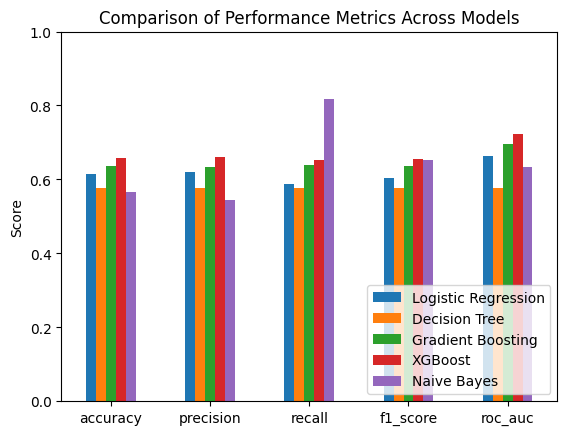

In [25]:
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
model_names = ['Logistic Regression', 'Decision Tree', 'Gradient Boosting', 'XGBoost', 'Naive Bayes']
all_results = [results_log_reg, results_decision_tree, results_gradient_boosting, results_xgboost, results_naive_bayes]

comparison = {metric: [] for metric in metrics}
for results in all_results:
    for metric in metrics:
        comparison[metric].append(results[metric])

# Create DataFrame
df = pd.DataFrame(comparison, index=model_names)

# Transpose DataFrame to switch rows and columns
df = df.T

# Plot comparison for each model
for model_name in model_names:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=df.index, y=df[model_name])
    plt.title(f'Comparison of Metrics for {model_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.show()

# Plot combined metrics comparison
plt.figure(figsize=(15, 10))
df.plot(kind='bar')
plt.title('Comparison of Performance Metrics Across Models')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()